## Can you accurately predict **insurance costs** ?

In [73]:
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
import warnings
warnings.simplefilter('ignore')

In [74]:
insurance_data = pd.read_csv('insurance-data.csv')
insurance_data.head(5)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [75]:
insurance_data.shape

(1338, 7)

In [76]:
print(insurance_data.duplicated().sum())
print(insurance_data[insurance_data.duplicated()])
data = insurance_data.drop_duplicates()


1
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [77]:
# show if data have null values or not
insurance_data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [78]:
print(data.shape)
print(data.dtypes)

(1337, 7)
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [79]:
# Encode Categorical data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['region'] = le.fit_transform(data['region'])



data.sample(5)

,age,sex,bmi,children,smoker,region,charges
1128,34,1,32.800,1,0,3,14358.36437
453,20,1,29.735,0,0,1,1769.53165
750,37,0,26.400,0,1,2,19539.24300
217,27,1,23.100,0,0,2,2483.73600
34,28,1,36.400,1,1,3,51194.55914


In [80]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,0.504862,30.663452,1.095737,0.204936,1.516081,13279.121487
std,14.044333,0.500163,6.100468,1.205571,0.403806,1.105208,12110.359656
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,0.000000,1.000000,4746.344000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9386.161300
75%,51.000000,1.000000,34.700000,2.000000,0.000000,2.000000,16657.717450
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


### EDA

<Axes: >

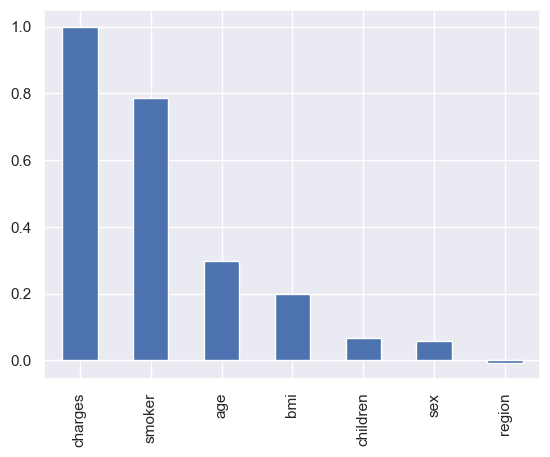

In [81]:
data.corr()['charges'].sort_values(ascending = False).plot(kind = 'bar')

<Axes: >

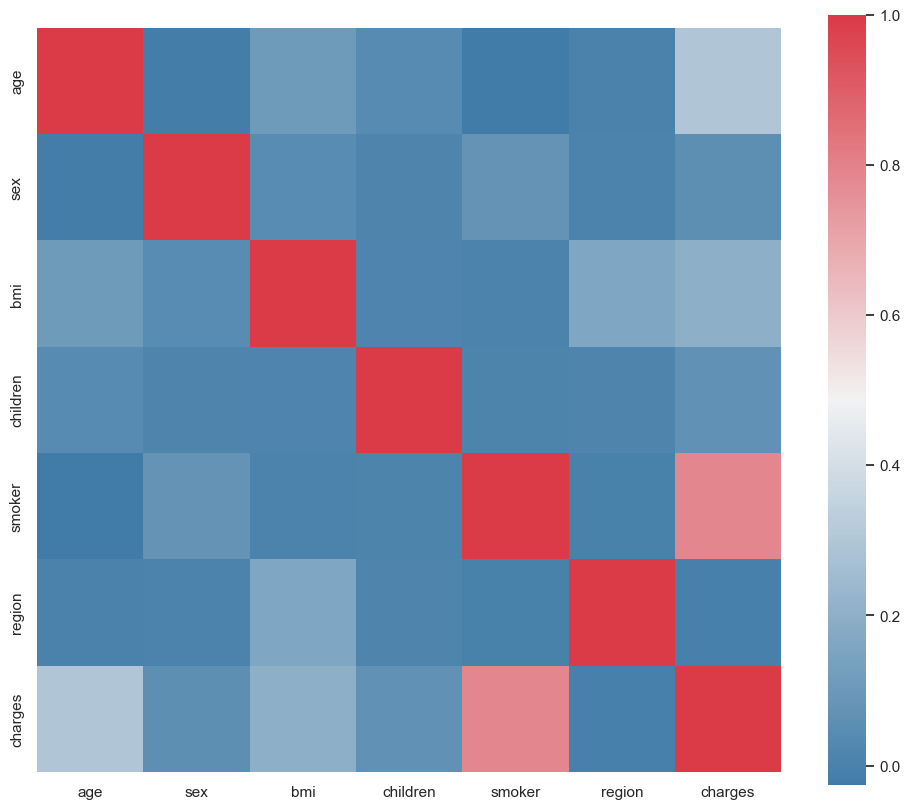

In [82]:
fig, axes = plt.subplots(figsize = (12, 10))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool_), cmap = sns.diverging_palette(240,10, as_cmap = True),
            square = True, ax = axes)

* A strong correlation is observed only with the fact of smoking the patient

In [83]:
# distribution of charges
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

p = figure(title = "Charges dist",tools = "save",
            background_fill_color = "#E8DDCB")
hist, edges = np.histogram(data.charges)
p.quad(top = hist, bottom = 0, left = edges[:-1], right = edges[1:],
        fill_color = "#036564", line_color = "#033649")

p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'Pr(x)'
show(gridplot([[p]], toolbar_location=None))


Text(0.5, 1.0, 'Charges for non-smokers Distribution')

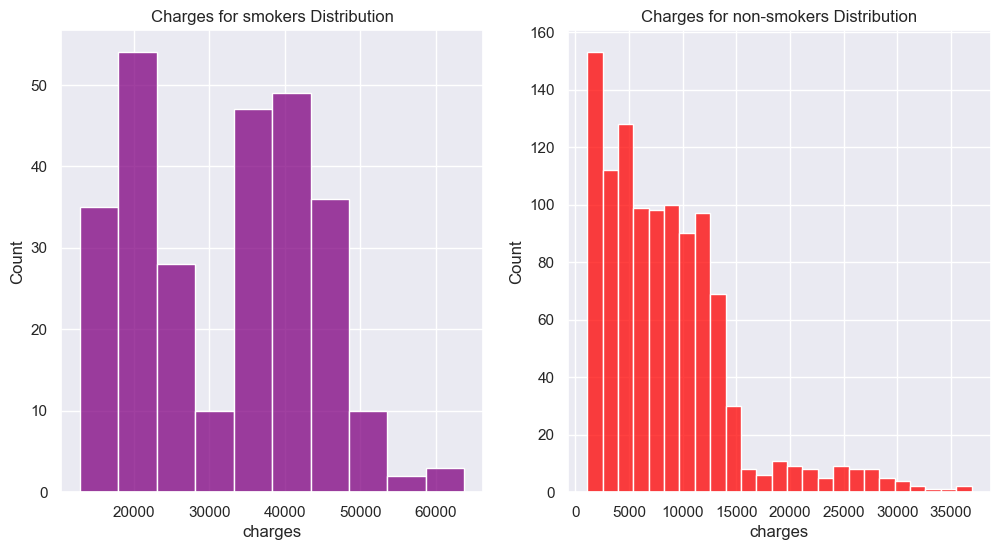

In [84]:
# Distribution of charges for smokers and non-smokers
f = plt.figure(figsize = (12, 6))
ax = f.add_subplot(121)
sns.histplot(data[data.smoker == 1]['charges'], color = 'purple', ax = ax)
ax.set_title('Charges for smokers Distribution')

ax = f.add_subplot(122)
sns.histplot(data[data.smoker == 0]['charges'], color = 'red', ax = ax)
ax.set_title('Charges for non-smokers Distribution')

* Smoking patients spend more on treatment

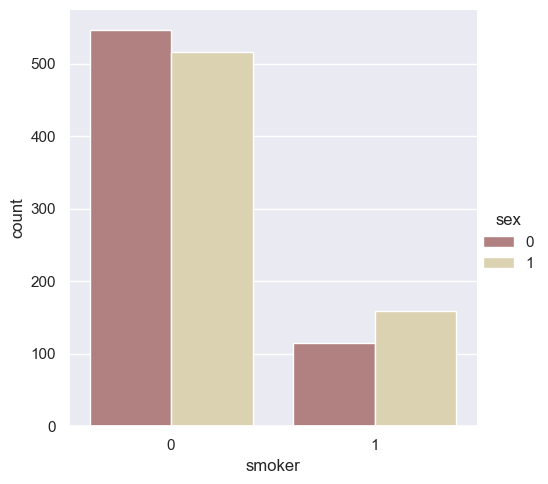

In [85]:
sns.catplot(x = "smoker", kind = "count",hue = 'sex', palette = "pink", data = data)

* we can notice that more male smokers than women smokers. It can be assumed that the total cost of treatment in men will be more than in women

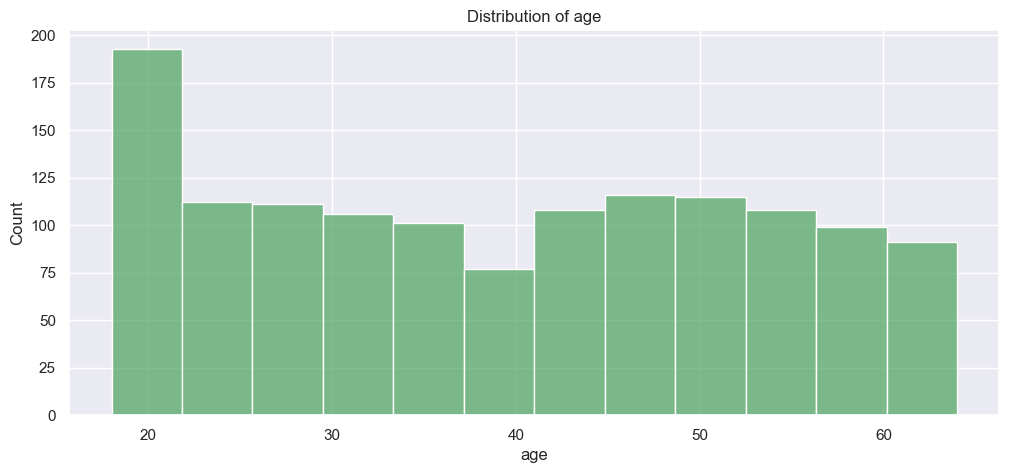

In [86]:
plt.figure(figsize = (12,5))
plt.title("Distribution of age")
ax = sns.histplot(data["age"], color = 'g')

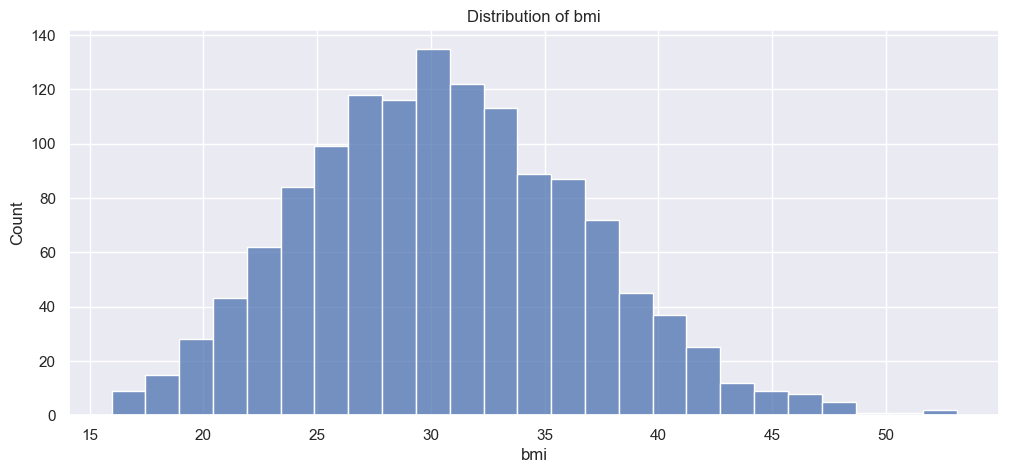

In [87]:
plt.figure(figsize = (12, 5))
plt.title("Distribution of bmi")
ax = sns.histplot(data["bmi"], color = 'b')

* The average BMI in patients is 30,  let's look at the distribution of costs in patients with BMI greater than 30 and less than 30.

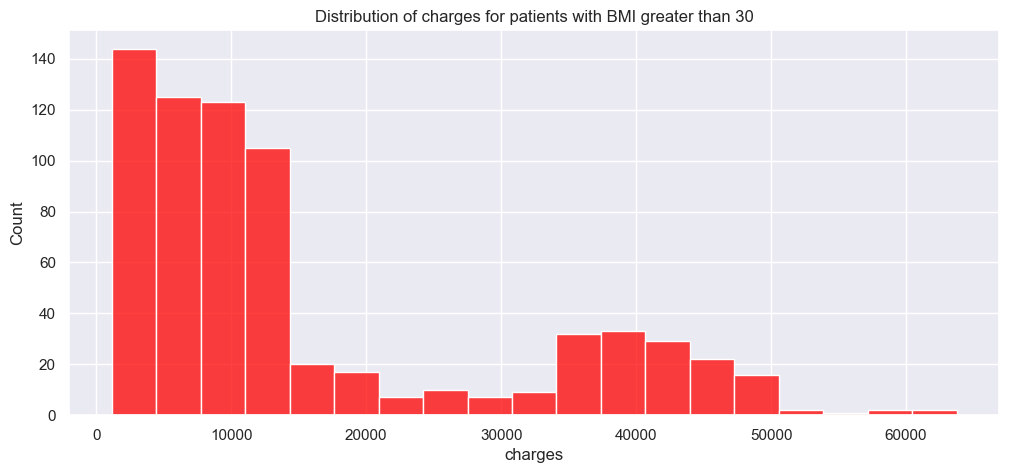

In [88]:
plt.figure(figsize = (12, 5))
plt.title('Distribution charges with BMI greater than 30')
ax = sns.histplot(data[data.bmi >= 30]['charges'], color = 'red')

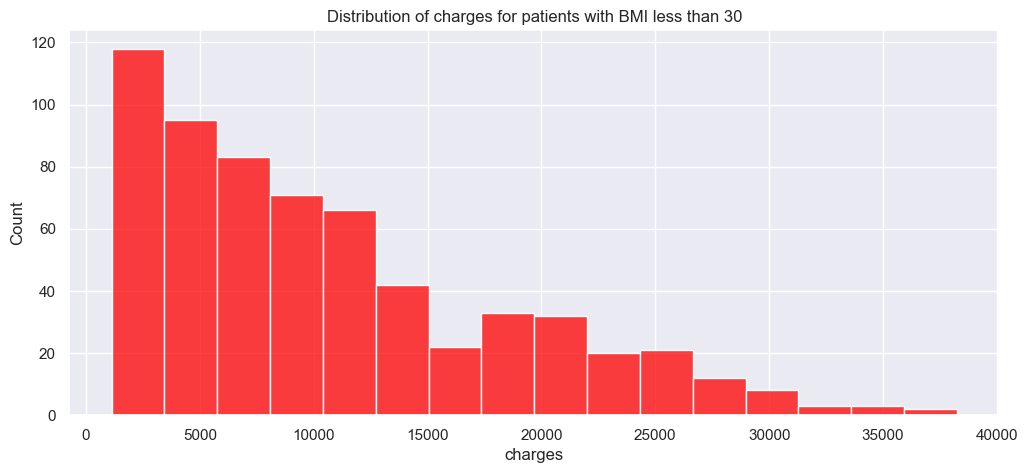

In [89]:
plt.figure(figsize = (12, 5))
plt.title('Distribution of charges for patients with BMI less than 30')
ax = sns.histplot(data[data.bmi < 30]['charges'], color = 'red')

 * Patients with BMI above 30 spend more on treatment!

* Most patients do not have children. Perfectly that some have 5 children!
* i wonder if people who have children smoke !

### Dealing with outliers

In [90]:
string_cols = insurance_data.select_dtypes('object').columns.to_list()
num_cols = insurance_data.copy().columns.to_list()
for i in string_cols:
    num_cols.remove(i)
num_cols

['age', 'bmi', 'children', 'charges']

### Modeling

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

In [92]:
# Feature Engineering

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

X = data.drop('charges', axis=1)
y = data['charges']

# Categorical columns for one-hot encoding
categorical_features = ['sex', 'smoker', 'region']
# Numerical columns for scaling
numerical_features = ['age', 'bmi', 'children']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Apply transformation
X_processed = preprocessor.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)


#### Linear Regression

In [93]:
x = X_processed
y = data['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

lr = LinearRegression()
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

lr.score(x_test,y_test)

0.7439511534750662

In [94]:
# add polynomial signs
X = data.drop(['charges'], axis = 1)
Y = data.charges


quad = PolynomialFeatures (degree = 3)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad, Y, random_state = 0)

plr = LinearRegression().fit(X_train, Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8415425167648876


#### K-Nearest Neighbors

In [95]:
x = data.drop(['charges'], axis = 1)
y = data.charges

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state = 0)

In [105]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': range(1, 30, 2),
    'weights': ['uniform', 'distance']
    }
knn = KNeighborsRegressor()
rs = GridSearchCV(knn, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rs.fit(X_train, Y_train)
print(rs.best_estimator_)
print("Best parameters:", rs.best_params_)
print("Best score (RMSE):", np.sqrt(-rs.best_score_))
knn = rs.best_estimator_

knn.fit(X_train, Y_train)
pred = knn.predict(X_test)

print('-'*60)
r2 = r2_score(Y_test, pred)
print('R2: ', r2)

err = np.sqrt(mean_squared_error(Y_test, pred))
print('Root Mean Squared Error: ', err)

knn_reg = ('KNN', r2, err)



KNeighborsRegressor(n_neighbors=19, weights='distance')
Best parameters: {'n_neighbors': 19, 'weights': 'distance'}
Best score (RMSE): 11156.430159758384
------------------------------------------------------------
R2:  0.18316370872869203
Root Mean Squared Error:  11415.424912002109


#### Random Forest

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

forest = RandomForestRegressor(n_estimators = 1000,
                               max_depth = 5,
                               max_features = 'log2',
                              criterion = 'friedman_mse',
                              min_samples_leaf = 1,
                              min_samples_split=0.001,
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train,Y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(Y_train,forest_train_pred),
mean_squared_error(Y_test,forest_test_pred)))

print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(Y_train,forest_train_pred),
r2_score(Y_test,forest_test_pred)))

MSE train data: 20525849.450, MSE test data: 30034874.943
R2 train data: 0.855, R2 test data: 0.812


In [108]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

# Random search of parameters
rf_random = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {rf_random.best_params_}")
print(f"Best score: {rf_random.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estim

In [109]:
# Use the best parameters
forest_best = RandomForestRegressor(**rf_random.best_params_)

# Fit the model
forest_best.fit(X_train, y_train)

# Predictions
forest_best_train_pred = forest_best.predict(X_train)
forest_best_test_pred = forest_best.predict(X_test)

# Evaluate
print('MSE train data: %.3f, MSE test data: %.3f' % (
    mean_squared_error(y_train, forest_best_train_pred),
    mean_squared_error(y_test, forest_best_test_pred)))

print('R2 train data: %.3f, R2 test data: %.3f' % (
    r2_score(y_train, forest_best_train_pred),
    r2_score(y_test, forest_best_test_pred)))

MSE train data: 9005398.971, MSE test data: 25376583.359
R2 train data: 0.937, R2 test data: 0.841


#### Neural Network

Epoch 1/500
26/26 [==============================] - 0s 5ms/step - loss: 285287232.0000 - val_loss: 311524704.0000
Epoch 2/500
26/26 [==============================] - 0s 4ms/step - loss: 166806704.0000 - val_loss: 157218720.0000
Epoch 3/500
26/26 [==============================] - 0s 4ms/step - loss: 120993072.0000 - val_loss: 157526704.0000
Epoch 4/500
26/26 [==============================] - 0s 4ms/step - loss: 119207856.0000 - val_loss: 156254704.0000
Epoch 5/500
26/26 [==============================] - 0s 4ms/step - loss: 122556848.0000 - val_loss: 158526448.0000
Epoch 6/500
26/26 [==============================] - 0s 4ms/step - loss: 119781760.0000 - val_loss: 156812912.0000
Epoch 7/500
26/26 [==============================] - 0s 4ms/step - loss: 117341656.0000 - val_loss: 154917856.0000
Epoch 8/500
26/26 [==============================] - 0s 4ms/step - loss: 116807520.0000 - val_loss: 155646144.0000
Epoch 9/500
26/26 [==============================] - 0s 4ms/step - loss: 1166689

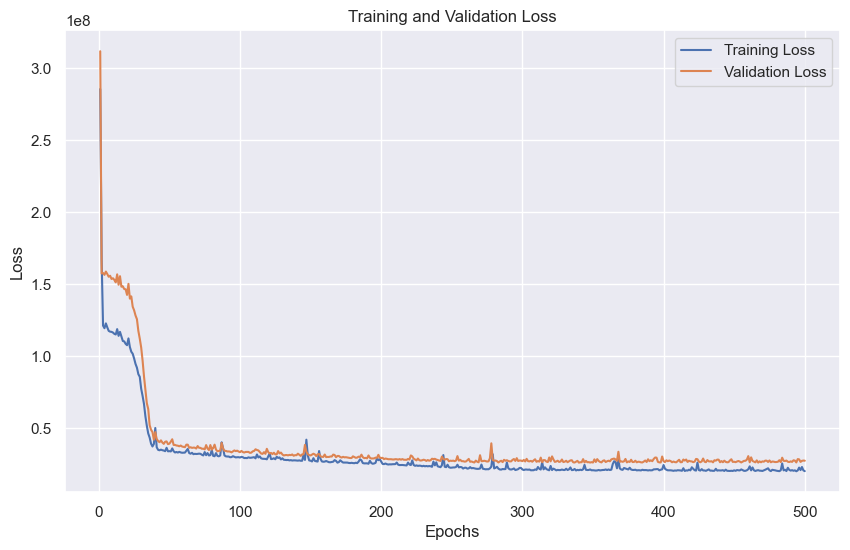

In [131]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Set a fixed random seed for reproducibility
tf.random.set_seed(22)

# Define the Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.mse)

# Train the model with a validation split
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2)

# Plotting the training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [132]:
model.evaluate(X_test, Y_test)

11/11 [==============================] - 0s 960us/step - loss: 26567692.0000


26567692.0

11/11 [==============================] - 0s 828us/step
0.8334653275945402
MSE: 26567690.64471358, RMSE: 5154.3855739276605
MAE: 2740.076361592747
Explained Variance: 0.84161270848359


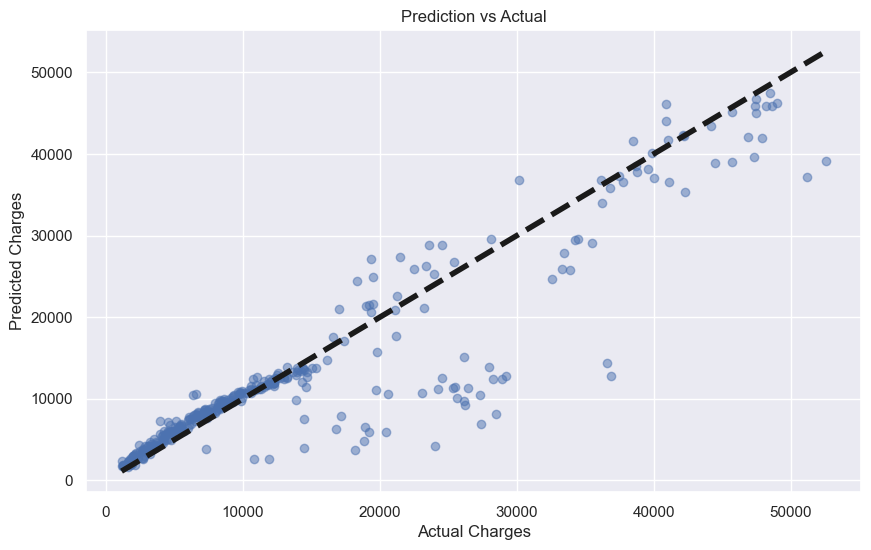

In [133]:
y_pred = model.predict(X_test)
print(r2_score(Y_test, y_pred))

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}, RMSE: {rmse}")

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, y_pred)
print(f"MAE: {mae}")


from sklearn.metrics import explained_variance_score

explained_variance = explained_variance_score(Y_test, y_pred)
print(f"Explained Variance: {explained_variance}")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
plt.show()

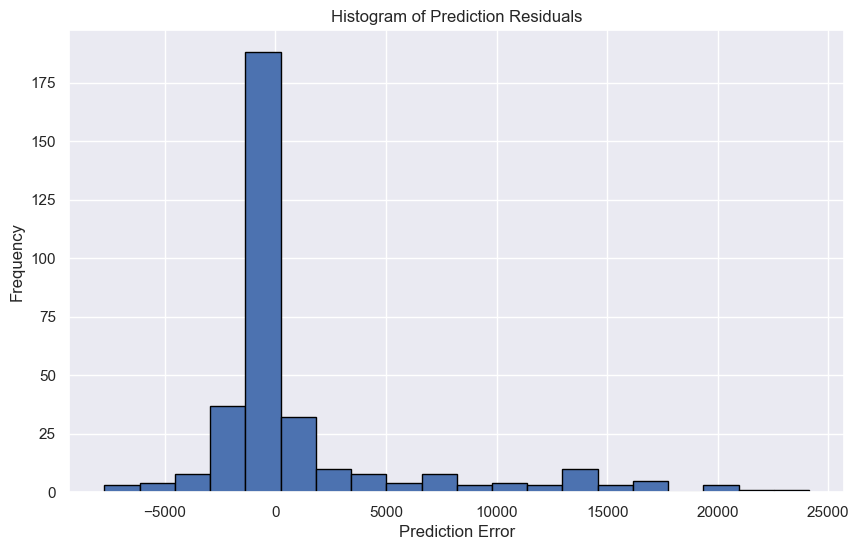

In [134]:
residuals = Y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Prediction Residuals')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()